<a href="https://colab.research.google.com/github/GhostBug-007/Cricket_Commentary_Classifier/blob/master/CricketCommentary_Classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

---
**Connect the Google Drive to retrieve the data**

In [41]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).




---


**Import all the necessary libraries for their functionalities**

In [42]:
import pandas as pd
import numpy as np

import nltk
import string 
import re
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from keras.models import Model
from keras.layers import LSTM, Activation, Dense, Dropout, Input, Embedding
from keras.optimizers import RMSprop
from keras.preprocessing.text import Tokenizer
from keras.preprocessing import sequence
from keras.utils import to_categorical
from keras.callbacks import EarlyStopping
from sklearn.metrics import mean_squared_error 
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_recall_fscore_support as result

%matplotlib inline

pd.set_option('display.max_colwidth', 100)
nltk.download('stopwords')                              # Download the Stopwords
nltk.download('wordnet')                                # Download the wordnet for Lemmatization

from nltk.stem import WordNetLemmatizer 
stopwords = nltk.corpus.stopwords.words('english')      # Getting the english Stopwords

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!




---


**Lets load the data**

--> ***training_data***, contains the training data <br>
--> ***testing_data***, contains the testing data

In [43]:
training_data = pd.read_excel (r'/content/drive/My Drive/dataset/Interns_ML_CaseStudy_Cricket Commentary/CCC_TrainingData.xlsx')
testing_data = pd.read_excel (r'/content/drive/My Drive/dataset/Interns_ML_CaseStudy_Cricket Commentary/CCC_TestData.xlsx')

---
**Making a dataframe from the CSV data to help data processing**





In [44]:
columnList = ["ID", "Match_ID", "Over", "Commentary", "Over_Run_Total", "Target"]
training_df = pd.DataFrame(training_data, columns= columnList)

---
**How does the dataFrame looks like!!**


In [45]:
training_df.head()

,ID,Match_ID,Over,Commentary,Over_Run_Total,Target
0,0,803965640511,49.6,and india reach 300. there has been a 300 in every first innings of this cup so far. shami driv...,4,Run_Bw_Wickets
1,1,803965640511,49.5,"slower ball, ashwin bunts this to leg for after walking down and realising he is early into th...",4,Run_Bw_Wickets
2,2,803965640511,49.4,"full toss on off, he just slogs, gets a thick edge for",4,Run_Bw_Wickets
3,3,803965640511,49.3,that's the closest you'll get to a hat-trick without actually getting it. lovely yorker. beats ...,4,Dot
4,4,803965640511,49.2,"sohail is doing the sajda after bowling rahane . slower ball, rahane makes room to try to hit i...",4,Wicket


---
**The Distribution of the outcomes for commentaries**

Text(0.5, 0, 'Target')

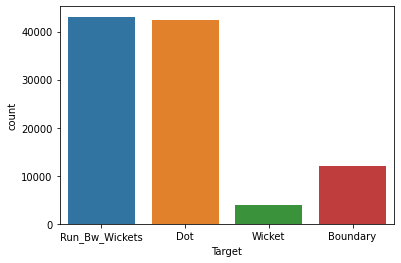

In [46]:
sns.countplot(training_df.Target)
plt.xlabel('Target')

In [47]:
print("Input has {} fields, {} are RBW, {} are dot, {} are wickets, {} are boundary".format(len(training_df),
                                                                                            len(training_df[training_df['Target'] == 'Run_Bw_Wickets']),
                                                                                           len(training_df[training_df['Target'] == 'Dot']),
                                                                                           len(training_df[training_df['Target'] == 'Wicket']),
                                                                                           len(training_df[training_df['Target'] == 'Boundary'])))

Input has 101634 fields, 43085 are RBW, 42522 are dot, 3893 are wickets, 12134 are boundary


---
**Loading the Lemmatizer** 


*Lemmatization is the process of setting a word to its base form <br>*
For example =>

> Thinking -> Think<br>
     ate -> eat



In [48]:
lemmatizer = WordNetLemmatizer()

---
The dataset contains certain words which are ![alt text](https://img.webmd.com/dtmcms/live/webmd/consumer_assets/site_images/article_thumbnails/other/virus_hospital_mask_white_01_other/virus_hospital_mask_white_01_other.jpg?resize=*:100px) in the commentary like **"boundary"**, **"out"**, **"catch"**, etc. which could reveal the action on the ball. <br>



In [49]:
masks = ['', '-999', '999']

---
The commentary data contains a lot of redundant data that needs to be cleaned


**Cleaning Begins** <br>


In [50]:
def clean_text(text):
    text = "".join([word for word in text if word not in string.punctuation])
    tokens = re.split('\W+', text)
    text = [lemmatizer.lemmatize(word) for word in tokens if word not in stopwords and word not in masks]
    return text

In [51]:
training_df['cleanData'] = training_df['Commentary'].apply(lambda x: clean_text(x.lower().strip()))
training_df.head()

,ID,Match_ID,Over,Commentary,Over_Run_Total,Target,cleanData
0,0,803965640511,49.6,and india reach 300. there has been a 300 in every first innings of this cup so far. shami driv...,4,Run_Bw_Wickets,"[india, reach, 300, 300, every, first, inning, cup, far, shami, drive, full, ball, point, come, ..."
1,1,803965640511,49.5,"slower ball, ashwin bunts this to leg for after walking down and realising he is early into th...",4,Run_Bw_Wickets,"[slower, ball, ashwin, bunt, leg, walking, realising, early, shot]"
2,2,803965640511,49.4,"full toss on off, he just slogs, gets a thick edge for",4,Run_Bw_Wickets,"[full, toss, slogs, get, thick, edge]"
3,3,803965640511,49.3,that's the closest you'll get to a hat-trick without actually getting it. lovely yorker. beats ...,4,Dot,"[thats, closest, youll, get, hattrick, without, actually, getting, lovely, yorker, beat, shami, ..."
4,4,803965640511,49.2,"sohail is doing the sajda after bowling rahane . slower ball, rahane makes room to try to hit i...",4,Wicket,"[sohail, sajda, bowling, rahane, slower, ball, rahane, make, room, try, hit, cover, top, leg, st..."


---
![alt text](https://miro.medium.com/max/1404/1*mu6G-cBmWlENS4pWHEnGcg@2x.jpeg)



In [52]:
vectorization = TfidfVectorizer(analyzer = clean_text, max_features = 100)

In [53]:
extractvector = vectorization.fit_transform(training_df['Commentary'])


In [54]:
features = pd.DataFrame(extractvector.toarray())
features.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99
0,0.0,0.0,0.000000,0.0,0.330622,0.0,0.317659,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.521922,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.456798,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.370210,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.414318,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
1,0.0,0.0,0.000000,0.0,0.000000,0.0,0.372190,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.611359,0.0,0.594795,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
2,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.522534,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.407903,0.0,0.415081,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.623122,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
3,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.351073,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.294939,0.0,0.0,0.0,0.487209,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.541385
4,0.0,0.0,0.327473,0.0,0.000000,0.0,0.211029,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.242867,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.250268,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.381522,0.0,0.0,0.000000,0.0,0.337245,0.0,0.0,0.210252,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.360222,0.0,0.0,0.0,0.0,0.0,0.0,0.000000


In [55]:
features.shape

(101634, 100)

---
**Let's divide and conquer** <br>

Train Split -> 75% <br>
Test Split -> 25%

In [56]:
X = features
Y = training_df['Target']
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.25)

In [57]:
print(X_train.shape)
print(X_test.shape)

(76225, 100)
(25409, 100)


---
Initializing the Random Forest Classifier 


> **n_estimators** -> Number of Decision Trees <br>
**max_depth**-> The maximum depth of the decision tree <br>
**n_jobs** -> Number of CPU's to use <br> 
**class_weight** -> Weightage of every outcome



In [58]:
rf = RandomForestClassifier(n_estimators = 100, max_depth=30, n_jobs=-1, class_weight='balanced')
rf_model = rf.fit(X_train, Y_train)

---
**Predicting the outcomes for the test split of the training dataset**

In [59]:
Y_pred = rf_model.predict(X_test)


---
![alt text](https://i.stack.imgur.com/7QIRU.gif)


---



> **tp** -> True Positives (Are positive and detected positive)<br>
**fp** -> False Positives (Are negative but detected positive)<br>
**tn** -> True Negatives (Are negative and detected negative)<br>
**fn** -> False Negatives (Are positive but detected negative)

In [60]:
precision, recall, fscore, support = result(Y_test, Y_pred, average='weighted')

In [61]:
print("Accuracy : {}%, Precision : {}, Recall : {}, Fscore : {}".format(round((Y_pred == Y_test).sum()*100/ len(Y_pred), 3),
                                                                       round(precision, 3),
                                                                       round(recall, 3),
                                                                       round(fscore, 3)))

Accuracy : 67.071%, Precision : 0.674, Recall : 0.671, Fscore : 0.669


**Model is Ready to make some predicitions!!**<br>
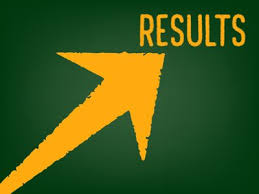

In [62]:
columnList = ["ID", "Commentary"]
testing_df = pd.DataFrame(testing_data, columns= columnList)
testing_df['cleanData'] = testing_df['Commentary'].apply(lambda x: clean_text(x.lower().strip()))

In [63]:
testing_df.head()

,ID,Commentary,cleanData
0,0,"the yorker gone wrong. low full toss, and dhoni has been waiting. he sends it sailing over midw...","[yorker, gone, wrong, low, full, toss, dhoni, waiting, sends, sailing, midwicket]"
1,1,"short of a length, no room, worked to leg for -999","[short, length, room, worked, leg]"
2,2,"good yorker, dhoni is making room, but can't get anything on this","[good, yorker, dhoni, making, room, cant, get, anything]"
3,3,raina is gone. finally to the short ball. but after having scored 74 off 56. this has hurried o...,"[raina, gone, finally, short, ball, scored, 74, 56, hurried, onto, taken, top, edge]"
4,4,"not called a wide. great call -999 say. he has moved inside the line, and he has been beaten ou...","[called, wide, great, call, say, moved, inside, line, beaten, outside, leg, might, wide, raina, ..."


In [64]:
testVec = vectorization.fit_transform(testing_df['Commentary'])
testVec.shape

(26143, 100)

In [65]:
res_features = pd.DataFrame(testVec.toarray())
res_features.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99
0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.325356,0.0,0.000000,0.0,0.000000,0.000000,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.490024,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.513448
1,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.000000,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.574978,0.0,0.348548,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.586861,0.000000
2,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.492977,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.322642,0.0,0.386874,0.000000,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.494186,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.508905
3,0.0,0.0,0.0,0.0,0.0,0.479514,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.704764,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.000000,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.522853,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000
4,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.418566,...,0.0,0.230373,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.647549,0.0,0.000000,0.000000


In [66]:
result = rf_model.predict(res_features)

In [67]:
testing_df['result'] = result

In [68]:
saveData = testing_df[['ID','result']]

In [69]:
saveData.head()                 #Shows the first 5 entries of the data frame

,ID,result
0,0,Boundary
1,1,Run_Bw_Wickets
2,2,Dot
3,3,Dot
4,4,Run_Bw_Wickets


In [70]:
print("Output has {} fields, {} are RBW, {} are dot, {} are wickets, {} are boundary".format(len(saveData),
                                                                                            len(saveData[saveData['result'] == 'Run_Bw_Wickets']),
                                                                                           len(saveData[saveData['result'] == 'Dot']),
                                                                                           len(saveData[saveData['result'] == 'Wicket']),
                                                                                           len(saveData[saveData['result'] == 'Boundary'])))

Output has 26143 fields, 9805 are RBW, 12403 are dot, 991 are wickets, 2944 are boundary


Text(0.5, 0, 'result')

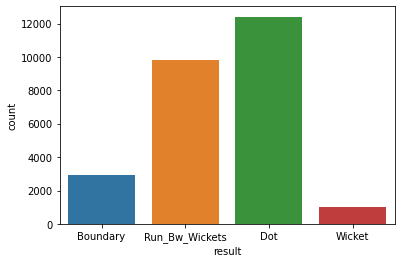

In [71]:
sns.countplot(saveData.result)
plt.xlabel('result')

In [36]:
saveData.to_excel('ResultFile_Prediction_.xlsx', index = False)



---

Thank You !!

---

